In [2]:
from collections import defaultdict
import numpy as np
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn

## lorenz series

In [3]:
# data generation 

N = 5
WINDOW_MIN = 8
WINDOW = 15

TRAIN_SIZE = 1000
VAL_SIZE = 200
TEST_SIZE = 200
PTS = 100

train_start = 0
train_end = TRAIN_SIZE

val_init = TRAIN_SIZE + WINDOW - 1
val_start = val_init - 1
val_end = val_start + VAL_SIZE

test_init = val_end + WINDOW - 1
test_start = test_init - 1
test_end = test_start + TEST_SIZE - WINDOW

# clusterize data

WISHART_K = 4
WISHART_H = 0.2

# generate predictions

STEPS, EPS = 50, 0.05
# STEPS, EPS = 60, 0.025

Q_VALUE = 0.99

In [4]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

## wishart clusterization

In [5]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))

    # print(max_diff)
    return max_diff >= h

def partition(dist, l, r, order):
    if l == r:
        return l

    pivot = dist[order[(l + r) // 2]]
    left, right = l - 1, r + 1
    while True:
        while True:
            left += 1
            if dist[order[left]] >= pivot:
                break

        while True:
            right -= 1
            if dist[order[right]] <= pivot:
                break

        if left >= right:
            return right

        order[left], order[right] = order[right], order[left]

def nth_element(dist, order, k):
    l, r = 0, len(order) - 1
    while True:
        if l == r:
            break
        m = partition(dist, l, r, order)
        if m < k:
            l = m + 1
        elif m >= k:
            r = m

def get_clustering(x, k, h, verbose=True):
    n = len(x)
    if isinstance(x[0], list):
        m = len(x[0])
    else:
        m = 1
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        nth_element(dist[i], order, k - 1)
        dk.append(dist[i][order[k - 1]])

    # print(dk)

    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [6]:
class WishartClusterization(object):
    def __init__(self, k, h):
        self.k = k
        self.h = h
        
    
    def fit(self, x):
        n = len(x)
        if isinstance(x[0], list):
            m = len(x[0])
        else:
            m = 1
        dist = squareform(pdist(x))

        dk = []
        for i in range(n):
            order = list(range(n))
            nth_element(dist[i], order, self.k - 1)
            dk.append(dist[i][order[self.k - 1]])

        # print(dk)

        p = [self.k / (volume(dk[i], m) * n) for i in range(n)]

        w = np.full(n, 0)
        completed = {0: False}
        last = 1
        vertices = set()
        for d, i in sorted(zip(dk, range(n))):
            neigh = set()
            neigh_w = set()
            clusters = defaultdict(list)
            for j in vertices:
                if dist[i][j] <= dk[i]:
                    neigh.add(j)
                    neigh_w.add(w[j])
                    clusters[w[j]].append(j)

            vertices.add(i)
            if len(neigh) == 0:
                w[i] = last
                completed[last] = False
                last += 1
            elif len(neigh_w) == 1:
                wj = next(iter(neigh_w))
                if completed[wj]:
                    w[i] = 0
                else:
                    w[i] = wj
            else:
                if all(completed[wj] for wj in neigh_w):
                    w[i] = 0
                    continue
                significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], self.h, p))
                if len(significant_clusters) > 1:
                    w[i] = 0
                    for wj in neigh_w:
                        if wj in significant_clusters:
                            completed[wj] = (wj != 0)
                        else:
                            for j in clusters[wj]:
                                w[j] = 0
                else:
                    if len(significant_clusters) == 0:
                        s = next(iter(neigh_w))
                    else:
                        s = next(iter(significant_clusters))
                    w[i] = s
                    for wj in neigh_w:
                        for j in clusters[wj]:
                            w[j] = s
        self.labels_ = w
        return self

## generate cluster centers

In [7]:
from itertools import groupby

def generate_centers(x_trains, WISHART_K=4, WISHART_H=0.2):
    ws = {}
    for pattern, train in x_trains.items():
        ws[pattern] = get_clustering(train, WISHART_K, WISHART_H)

    centers = {}
    
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))

    return centers

## windows functions 

In [8]:
import itertools

def generate_subsequences(window, num, short=False):
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

## sampling

In [9]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

def gen_sample_in_point(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

def gen_sample_in_point_with_q(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    
def generate_sample(values, window, pattern, put_none=False):
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result

def aggr(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

## errors 

In [10]:
def calc_mae(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            result += abs(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return result / predictable

def calc_rmse(actual, predictions, step):
    result = 0
    predictable = 0
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            result += np.square(actual[start_point + step] - preds[start_point + step])
            predictable += 1
    if predictable == 0:
        return None
    return sqrt(result / predictable)

def calc_non_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if not preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_predictable(actual, predictions, step):
    result = 0
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            result += 1
    return result / len(predictions) * 100

def calc_metric_for_steps(actual, predictions, calc_metric):
    result = [None]
    for step in range(1, STEPS + 1):

        result.append(calc_metric(actual, predictions, step))
    return result

def calc_mae_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_mae)

def calc_rmse_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_rmse)

def calc_non_predictable_for_steps(actual, predictions):
    return calc_metric_for_steps(actual, predictions, calc_non_predictable)

def calc_predictable_for_steps(actual, predictions):    
    return calc_metric_for_steps(actual, predictions, calc_predictable)

## generate predictions

In [11]:
from tqdm import trange, tqdm

def generate_predictions(centers, deamon=None, return_set_pred=False, real_mode='test',
                          EPS=0.05, Q_VALUE=0.99):
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = val_end
        init_point = test_init
    else:
        end_point = train_end
        init_point = val_init

    print("BIMBAAAAA")
    print(end_point, init_point)

    for start_point in tqdm(range(PTS)):
        
        # initialize empty
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        # current window
        wind = list(map(lambda x: (x, 1), xs[end_point + start_point : init_point + start_point]))

        for step in range(1, STEPS + 1):
            x_tests_for_point = {}
            for pattern in patterns:
                
                key = str_subseq(pattern + (WINDOW - 1,)) 
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]), 
                                                    WINDOW, pattern, len(wind))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample

            chosen_centers = []
            for pattern, centers_values in centers.items():
                if not x_tests_for_point[pattern]:
                    continue
                vector = np.array(x_tests_for_point[pattern][:-1])[:, 0]
                q_values = np.array(x_tests_for_point[pattern][:-1])[:, 1]

                for center in centers_values:
                    dist = euclidean(vector, center[:-1])
                    if dist < EPS:
                        weight_d = (EPS - dist) / EPS
                        weight_q = np.mean(q_values) * Q_VALUE
                        chosen_centers.append((pattern, center, weight_d, weight_q))

            last_points = list(map(lambda center: (center[1][-1], center[2], center[3], center[0]), 
                                  chosen_centers))
            
            # deamon predict
            result_point = deamon.predict(start_point, step, last_points)
            preds[start_point].append(result_point)

            if return_set_pred:
                set_preds[start_point].append(last_points)

            
            if result_point:
                q_value = np.mean(np.array(list(map(lambda center: center[2], 
                                  chosen_centers))))
            else:
                q_value = None
            
            # move the window
            # print("window: ", wind[1:], "[res, q_value]: ", [(result_point, q_value)])
            # wind = np.concatenate([wind[1:], [(result_point, q_value)]])
            wind = np.concatenate([wind, [(result_point, q_value)]])

    deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds

## aggregate predictions with weights

In [12]:
def simple_aggr(pts):
  if not pts:
        return None
  return np.mean(np.array(list(map(lambda center: center[0], pts))))

def aggr_d(pts):
    # weighted sum by distance
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

def aggr_q(pts):
    # weighted sum by q-value
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight

def aggr_mix(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1] * center[2], pts))
    pred = sum(map(lambda center: center[0] * center[1] * center[2], pts))
    return pred / sum_weight

## demon metrics visualizion

In [13]:
def add_preds(preds, daemon, filtered_preds):
    preds[daemon] = filtered_preds

def get_metrics(daemons, actual, return_values=False, plot=True):
    preds = {}
    
    for daemon in daemons:
        add_preds(preds, daemon[1], daemon[0].get_predictions())
    
    mae, rmse, non_pred = plot_daemons_result(actual, preds, plot=plot)

    if return_values:
        return mae, rmse, non_pred

def print_metrics_for_subplot(metrics, ax, title):
    for values, label in metrics:
        ax.plot(values[:-1], label=label)
    ax.set_title(title)
    ax.legend(loc='best')
    #ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_xticks(np.arange(0, STEPS + 1, 5))
    ax.grid()

def print_metric_for_subplot(func, metric_name, actual, daemons_predictions, ax, plot=True):
    metrics = []
    for label, pred in daemons_predictions.items():
        metrics.append([func(actual, pred), label])
    if plot:
        print_metrics_for_subplot(metrics, ax, metric_name)

    return metrics

def plot_daemons_result(actual, daemons_predictions, plot=True):
    if plot:
        fig, ax = plt.subplots(2, 2, figsize=(20,10))
        fig.tight_layout()
    else:
        ax = np.zeros((2,2))
    mae = print_metric_for_subplot(calc_mae_for_steps, 'MAE', actual, daemons_predictions, ax[0][0], plot=plot)
    rmse = print_metric_for_subplot(calc_rmse_for_steps, 'RMSE', actual, daemons_predictions, ax[0][1], plot=plot)
    non_pred = print_metric_for_subplot(calc_non_predictable_for_steps, 'non-predictable (%)', actual, daemons_predictions, ax[1][0], plot=plot)
    print_metric_for_subplot(calc_predictable_for_steps, 'predictable (%)', actual, daemons_predictions, ax[1][1], plot=plot)
    if plot:
        plt.show()

    return mae, rmse, non_pred

## divergence visualization

In [14]:
def visualize_point(preds, point, real_vals, plot_all_points=None, plot_tube_points=None,
                    highlight_point=None, plot_res_tube=None, offset=3):
    plt.figure(figsize=(20, 8))
    colors=['green', 'red', 'orange']

    limits_real = [point - offset, point + STEPS + offset]
    plt.plot(
        range(limits_real[0], limits_real[1]),
        real_vals[limits_real[0]:limits_real[1]], 
        label='real values'
    )

    limits_predictions = [point, point + STEPS]
    for i, pred in enumerate(preds):
        plt.plot(
            range(limits_predictions[0], limits_predictions[1]),
            pred[0].get_predictions()[point][limits_predictions[0]:limits_predictions[1]], 
            label=pred[1], 
            marker='o', 
            markersize=2,
            c=colors[i]
        )

        if plot_all_points:
            for step in plot_all_points:
                raw_preds = pred[0].get_set_predictions()[point][point + step]
                set_preds = list(map(lambda x: x[0], raw_preds))
                plt.scatter([point + step for i in range(len(set_preds))], 
                            set_preds, alpha=0.2, color='red')
    if highlight_point:
        plt.plot(
            point + highlight_point,
            pred[0].get_predictions()[point][point + highlight_point], 
            label='bad', 
            marker='o', 
            markersize=10, 
            color="purple"
        )

    if plot_res_tube is not None:
        plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), plot_res_tube, label='tube avg')

    if plot_tube_points is not None:
        for tr in plot_tube_points:
            plt.plot(range(limits_predictions[0] + 1, limits_predictions[1] + 1), tr, alpha=0.3, linestyle='--')

    

    plt.scatter([point], real_vals[point], label='start')
    plt.axvline(x=(point + 1), linewidth=0.5, color='r', label="step 1")
    for mark in range(5, STEPS + 1, 5):
        plt.axvline(x=(point + mark), linewidth=0.5, color='r', label="step " + str(mark))

    plt.title("Divergence")
    plt.xlabel("point")
    plt.ylabel("Lorenz value")
    plt.legend()

## histogram utils

In [15]:
# def plot_hist_for_fixed_point(start_point, step, set_preds, y_limit=30):
#     fig = plt.figure(figsize=(15, 5))
#     modes = ['simple', 'q-value', 'dist', 'mix']
#     for i, mode in enumerate(modes):
#         ax = fig.add_subplot(2, 2, i + 1)
#         pred, preds, weights = get_weights(start_point, step, mode, set_preds)

#         vals = ax.hist(preds, weights=weights, bins=100, range=(0, 1), label='preds')
                    
#         ax.plot([pred for i in range(2)], [0, y_limit], c='green', label='simple_pred')
#         ax.plot([x_test[start_point + step] for i in range(2)], [0, y_limit], c='red', 
#                 label='real')
#         ax.legend(loc='upper left')
#         ax.set_title('Mode: ' + mode  + ' || Start:' + str(start_point) + ' || Step ahead:' + str(step))
#         ax.set_ylim(0, y_limit)
        
#         fig.tight_layout() 

In [16]:
def get_points(step, mae_threshold, predictions):
    good_points = []
    bad_points = []
    for start_point, preds in predictions.items():
        if preds[start_point + step]:
            mae = abs(x_test[start_point + step] - preds[start_point + step])
            if mae > mae_threshold:
                bad_points.append(start_point)
            else:
                good_points.append(start_point)
    return good_points, bad_points

## mode weights

In [17]:
def get_weights(start, step, mode, set_predictions):
    return get_weights_with_preds(set_predictions[start][start + step], mode)

def get_weights_with_preds(set_preds, mode):
    preds = list(map(lambda x: x[0], set_preds))
    pred = simple_aggr(set_preds)

    if mode == 'simple':
        weights = np.ones(len(preds))
    elif mode == 'q-value':
        pred = aggr_q(set_preds)
        weights = list(map(lambda x: x[2], set_preds))
    elif mode == 'dist':
        pred = aggr_d(set_preds)
        weights = list(map(lambda x: x[1], set_preds))
    elif mode == 'mix':
        pred = aggr_mix(set_preds)
        weights = list(map(lambda x: x[1] * x[2], set_preds))

    return pred, preds, weights

# 2 Initial research


## generate lorenz

In [25]:
xs, _, _ = Lorentz().generate(0.1, 1000)
xs = (xs - xs.min()) / (xs.max() - xs.min())

In [26]:
x_train = xs[train_start:train_end]
x_val = xs[val_start:val_end]
x_test = xs[test_start:test_end]

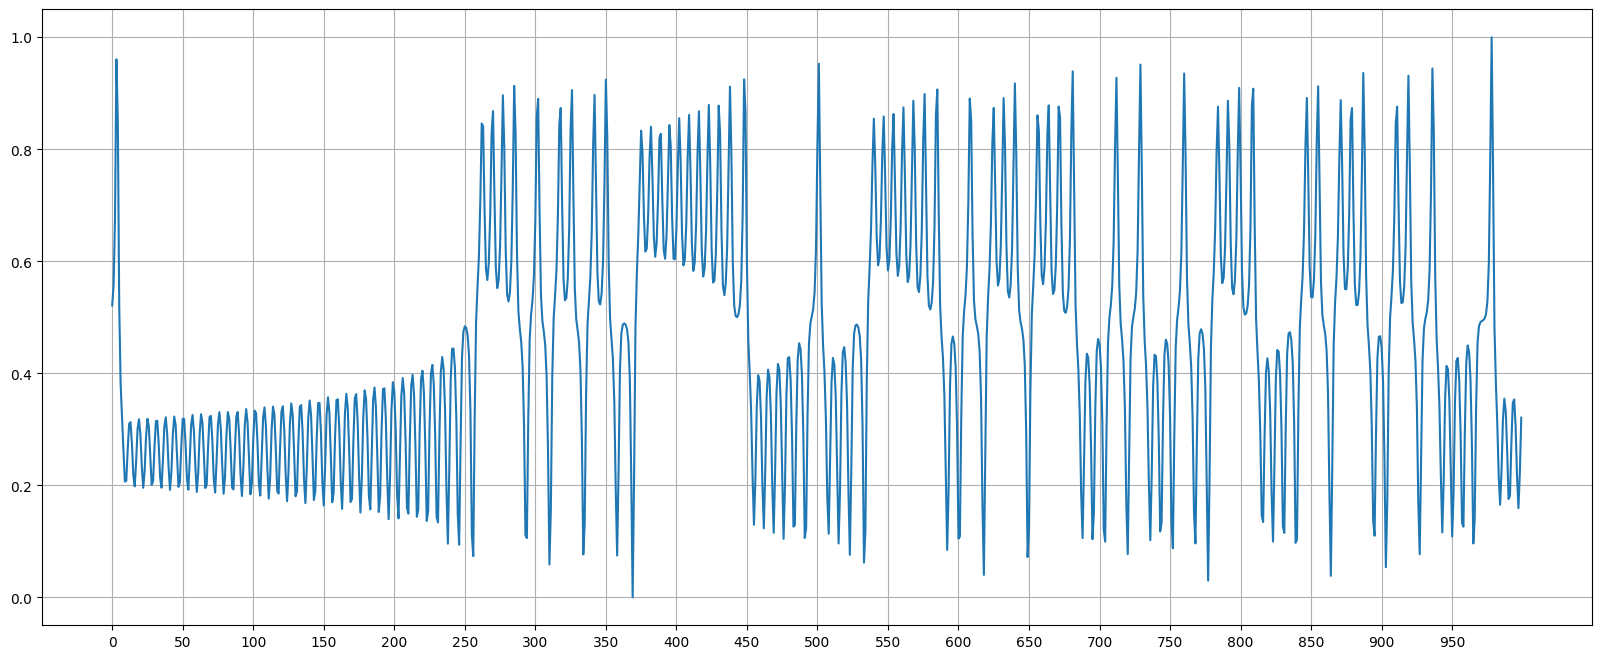

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

## generate data


In [28]:
def generate_patterns():
    patterns1 = generate_subsequences(WINDOW_MIN - 1, N - 1, short=True)
    patterns2 = generate_subsequences(WINDOW - 1, N - 1)
    patterns3 = random.choices(patterns2[300:], k=35)
    
    return patterns1 + patterns3

In [29]:
x_trains = {}
patterns = generate_patterns()

for pattern in patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
    
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

In [31]:
patterns

[(7, 8, 9, 10),
 (7, 8, 9, 11),
 (7, 8, 9, 12),
 (7, 8, 9, 13),
 (7, 8, 10, 11),
 (7, 8, 10, 12),
 (7, 8, 10, 13),
 (7, 8, 11, 12),
 (7, 8, 11, 13),
 (7, 8, 12, 13),
 (7, 9, 10, 11),
 (7, 9, 10, 12),
 (7, 9, 10, 13),
 (7, 9, 11, 12),
 (7, 9, 11, 13),
 (7, 9, 12, 13),
 (7, 10, 11, 12),
 (7, 10, 11, 13),
 (7, 10, 12, 13),
 (7, 11, 12, 13),
 (8, 9, 10, 11),
 (8, 9, 10, 12),
 (8, 9, 10, 13),
 (8, 9, 11, 12),
 (8, 9, 11, 13),
 (8, 9, 12, 13),
 (8, 10, 11, 12),
 (8, 10, 11, 13),
 (8, 10, 12, 13),
 (8, 11, 12, 13),
 (9, 10, 11, 12),
 (9, 10, 11, 13),
 (9, 10, 12, 13),
 (9, 11, 12, 13),
 (10, 11, 12, 13),
 (2, 3, 9, 11),
 (4, 5, 10, 12),
 (1, 3, 8, 12),
 (1, 5, 10, 11),
 (1, 9, 10, 12),
 (3, 9, 11, 12),
 (2, 3, 5, 12),
 (2, 3, 5, 7),
 (1, 2, 5, 11),
 (2, 7, 8, 13),
 (1, 4, 8, 9),
 (1, 2, 8, 9),
 (1, 2, 10, 11),
 (6, 7, 9, 13),
 (3, 4, 9, 11),
 (1, 3, 8, 11),
 (1, 4, 6, 11),
 (3, 4, 6, 8),
 (5, 6, 8, 11),
 (3, 5, 9, 12),
 (3, 6, 10, 11),
 (4, 5, 8, 9),
 (2, 6, 7, 8),
 (1, 5, 6, 11),
 (3, 4, 12,

## clusterize train data

In [30]:
centers = generate_centers(x_trains)

## demons approximation

### Simple deamon

In [30]:
class SimpleDeamon(object):
    def __init__(self, mode='simple'):
        self.mode = mode
        self.predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}
        self.set_predictions = {point : [None for i in range(point + 1)] for point in range(PTS)}

        self.predicted = False
        
    @property
    def label(self):
        return 'Simple model of demon with ' + self.mode + ' mode'

    def predict(self, start_point, step, preds):
        self.set_predictions[start_point].append(preds)

        if self.mode == 'simple':
            pred = simple_aggr(preds)
        elif self.mode == 'd_weighted':
            pred = aggr_d(preds)
        elif self.mode == 'q_weighted':
            pred = aggr_q(preds)
        elif self.mode == 'mix':
            pred = aggr_mix(preds)

        self.predictions[start_point].append(pred)
        return pred
    
    def get_predictions(self):
        return self.predictions
    
    def get_set_predictions(self):
        return self.set_predictions

    def is_predicted(self):
        return self.predicted

## generate predictions

In [ ]:
Simple_deamon_d_val = SimpleDeamon(mode='d_weighted')
Simple_deamon_q_val = SimpleDeamon(mode='q_weighted')
Simple_deamon_mix_val = SimpleDeamon(mode='mix')

demons_set = [
           Simple_deamon_d_val,
           Simple_deamon_q_val,
           Simple_deamon_mix_val
]

for demon in demons_set:
    generate_predictions(centers, deamon=demon, real_mode='val')

## Visualisation of predictions

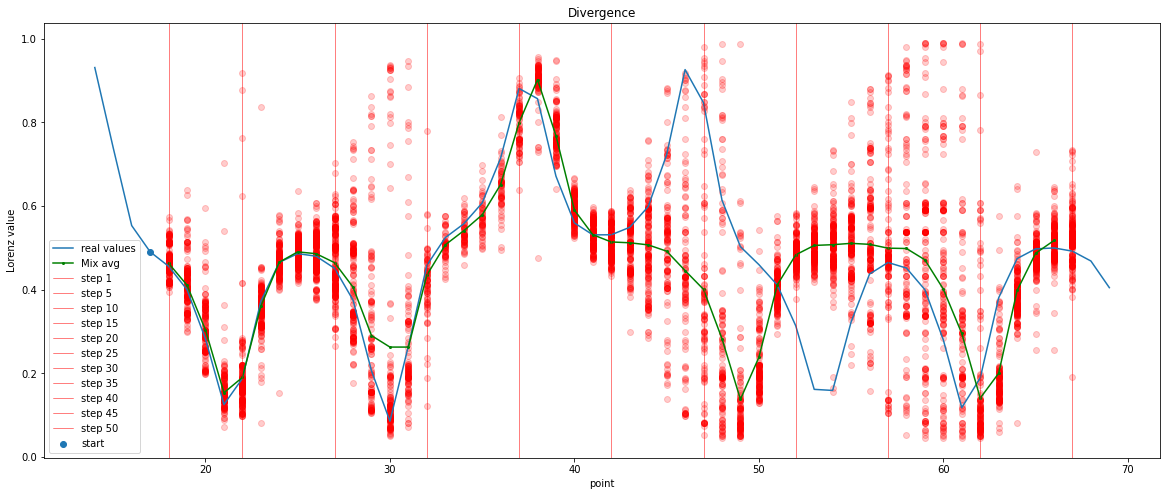

In [ ]:
visualize_point([
                 (Simple_deamon_mix_val, 'Mix avg')
                ], 
                17,
                real_vals=x_val,
                plot_all_points=[i for i in range(1, STEPS +1)]
)